# A short demo of PyArrow & Neo4j 😀
<img src="https://arrow.apache.org/docs/_static/arrow.png" style="width:200px;">

## Our Dependencies
Nothing special really...the usual cast of characters with the addition of `pyarrow`

In [1]:
%pip install pyarrow pandas scikit-learn matplotlib seaborn
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


### Imports and our Integration
We'll set up our imports next.

One special import is [neo4j_arrow](https://gist.github.com/voutilad/ac1107a383affcdfdaaf4a08d1f14df4), the client wrapper to simplify talking to the server-side `Neo4j-Arrow` service. It's like **100 lines of Python** and uses the `PyArrow` framework...no Neo4j code!

> Server-side it exists as a database plugin. If you have access, the code is here: https://github.com/neo4j-field/neo4j-arrow

In [2]:
# Get our DS imports ready!
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# To time stuff...
import time

# And our neo4j integration!
import neo4j_arrow

---

## Connecting our Neo4jArrow Client
Very simple. We provide access credentials (username, password) and then provide the location of the server in a tuple of `(host, port)`.

`Neo4jArrow` uses Neo4j's built-in authorization framework. All our calls to the server are authenticated like any other Neo4j client.

In [3]:
client = neo4j_arrow.Neo4jArrow('neo4j', 'password', ('voutila-arrow-test', 9999))

### Discovering Available Actions
Arrow Flight uses an RPC concept. In short, clients can perform _Actions_ sending optional payload data to the server with each action. Clients can also consume or put _streams_ to/from the server.

Let's discover our available actions!

In [4]:
actions = client.list_actions()

for action in actions:
  print(action)

ActionType(type='cypherRead', description='Submit a new Cypher-based read job')
ActionType(type='cypherWrite', description='Submit a new Cypher-based write job')
ActionType(type='jobStatus', description='Check the status of a Job')
ActionType(type='gdsNodeProperties', description='Stream node properties from a GDS Graph')
ActionType(type='gdsRelProperties', description='Stream relationship properties from a GDS Graph')


Each of these actions can be called by an Apache Arrow client, regardless if it's PyArrow or the Arrow R package or Arrow for Rust!

---

## Working with Cypher Jobs
The way I've architected `Neo4jArrow` is designed around submitting "jobs" that construct streams. Let's submit some Cypher!

In [5]:
cypher = """
  UNWIND range(1, $i) AS n
  RETURN n, [_ IN range(1, $j) | rand()] AS embedding
"""
params = {
    "i": 1_000_000,
    "j": 128
}

print(f"Submitting cypher with params:\n{cypher}\n{params}")

ticket = client.cypher(cypher, params=params)

print(f"Got a ticket: {ticket}")

Submitting cypher with params:

  UNWIND range(1, $i) AS n
  RETURN n, [_ IN range(1, $j) | rand()] AS embedding

{'i': 1000000, 'j': 128}
Got a ticket: <Ticket b'b5f465df-fccb-4dd0-926a-6ae3104f02ce'>


### Waiting for our Results
Each job results in a _ticket_. Clients use the ticket to check on job status or request a stream of the results.

Let's wait until our Cypher is producing results and our stream is ready for consumption. This little helper function just polls the `jobStatus` _Action_ waiting for our job to be in a "producing" state.

In [6]:
print(f'Polling for status on ticket {ticket}...')
ready = client.wait_for_job(ticket, timeout=5)
if not ready:
    raise Exception('something is wrong...did you submit a job?')
else:
    print('...Stream is Ready!')

Polling for status on ticket <Ticket b'b5f465df-fccb-4dd0-926a-6ae3104f02ce'>...
...Stream is Ready!


### Consuming our Results
Clients consume streams by presenting their ticket. They bet back a PyArrow stream reader and have some options to how they consume the stream:

1. They can iterate over batches in the stream and process them incrementally.
2. They can consume the entire stream into a PyArrow Table
3. They can consume the entire stream immediately into a Pandas data frame

In [7]:
# Let's get a dataframe!
print('>> Reading the result of our Cypher job into a dataframe. Please wait...')

start = time.time()
table = client.stream(ticket).read_all()
delta = round(time.time() - start, 1)

print(f'>> Read our stream entirely into a PyArrow table in {delta} seconds!')
print(table)
megs = table.to_pandas().memory_usage(deep=True)
print(f"How big is our data? (in MiB)")
megs / (1024 * 1024)

>> Reading the result of our Cypher job into a dataframe. Please wait...
>> Read our stream entirely into a PyArrow table in 9.9 seconds!
pyarrow.Table
embedding: list<embedding: double>
  child 0, embedding: double
n: int64
How big is our data? (in MiB)


Index          0.000122
embedding    106.811523
n              7.629395
dtype: float64

#### Let's Work with Pandas and Scikit-Learn!

In [8]:
# We'll convert our series of arrays into a NumPy matrix
print("Converting to a Pandas DataFrame...")
df = table.select(['embedding'])[0].to_pandas()

print("Building a NumPy matrix...")
m = np.matrix(df.tolist())

# Then let's do dimensional reduction so we can plot our vectors
pca = PCA(n_components=2)
print("Fitting PCA transform...")
pc = pca.fit_transform(m)

print('Before, our data looked like :')
print(table.select(['embedding'])[0][0:1])

print('Now we have a matrix like:')
print(pc)

Converting to a Pandas DataFrame...
Building a NumPy matrix...
Fitting PCA transform...
Before, our data looked like :
[
  [
    [
      0.439433,
      0.836573,
      0.149615,
      0.25475,
      0.0974362,
      0.513586,
      0.0136285,
      0.878828,
      0.204227,
      0.386368,
      ...
      0.114259,
      0.754134,
      0.881492,
      0.0332541,
      0.182821,
      0.436564,
      0.194598,
      0.0241677,
      0.831682,
      0.27685
    ]
  ]
]
Now we have a matrix like:
[[-0.30134844 -0.57491504]
 [-0.04344058  0.33979949]
 [ 0.64478107  0.17657788]
 ...
 [ 0.43768933  0.5614301 ]
 [ 0.46818049  0.5336102 ]
 [-0.02292352 -0.39342578]]


Let's plot!

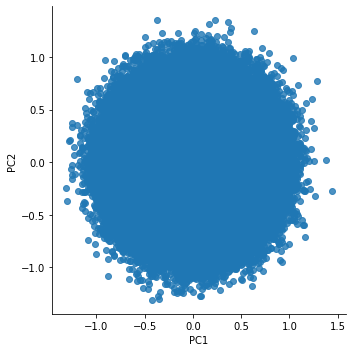

In [9]:
pc_df = pd.DataFrame(data=pc, columns=['PC1', 'PC2'])
sns.lmplot( x="PC1", y="PC2",
  data=pc_df,
  fit_reg=False)

---

## Now for the fun stuff: Direct GDS Integration!
We just played with Cypher, which is fine...but what about working with _even more data_ from things like GDS?

Our traditional methods using the Python driver would absolutely choke here...but with PyArrow, I can stay in my comfy little Python world and still get data _fast_.

### Submitting a GDS Job
We'll submit a GDS job that reads directly from the in-memory graph. In this case, it's analagous to something like:

```
CALL gds.graph.streamNodeProperties('mygraph', ['embedding'])
```

Suppose we already have this graph populated via something like:

```
CALL gds.graph.create('mygraph', 'Node', { EDGE: { orientation: 'UNDIRECTED'} });
CALL gds.fastRP.mutate('mygraph', {
    embeddingDimension: 256,
    mutateProperty: 'embedding'
});
```

> Note that this follows the same general flow as before: submit job, get ticket, get stream

In [10]:
# Time for something completely different...
# Submit our GDS job to retrieve some node embeddings from a graph projection
ticket = client.gds_nodes('mygraph', ['embedding'])
client.wait_for_job(ticket, timeout=5)

print('''Reading the result of our GDS job into a dataframe.
Please be patient...this takes a minute or two (quite literally)...''')

# Retrieve and consume the stream directly into a Pandas DataFrame (and time it)
start = time.time()
df = client.stream(ticket).read_pandas()
delta = round(time.time() - start, 1)

# Voila!
print(f'Read our stream entirely into a dataframe in {delta} seconds!')
print(df)
print(f'Our dataframe has {len(df):,} vectors')
print('Memory usage looks like (in MiB):')
df.memory_usage(deep=True) / (1024 * 1024)

Reading the result of our GDS job into a dataframe.
Please be patient...this takes a minute or two (quite literally)...
Read our stream entirely into a dataframe in 61.5 seconds!
          nodeId                                          embedding
0         229376  [0.008602902, 0.016927008, -0.028940432, -0.08...
1         229377  [0.032899458, -0.08328128, 0.0, -0.056388523, ...
2         229378  [-0.12376026, -0.0153484335, 0.020201022, -0.0...
3         229379  [-0.008657373, 0.08211225, -0.02738031, 0.0241...
4         229380  [-0.08148586, -0.12803231, 0.09086605, -0.2530...
...          ...                                                ...
9999995  9999995  [-0.101765685, -0.017179396, -0.0674069, -0.02...
9999996  9999996  [0.02445675, -0.047333244, -0.061222896, 0.0, ...
9999997  9999997  [-0.11131857, 0.012987506, 0.033491958, -0.019...
9999998  9999998  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9999999  9999999  [-0.13822165, -0.050849244, -0.007947987, -0.0...

[100

Index           0.000122
nodeId         76.293945
embedding    1068.115234
dtype: float64

Now we'll do our little data conversion and PCA...

In [11]:
# Select out just our embedding vectors and convert it to a numpy matrix
df = table.select(['embedding'])[0].to_pandas()
m = np.matrix(df.tolist())

# Then let's do dimensional reduction so we can plot our vectors in a lower dimension
pca = PCA(n_components=3)
pc = pca.fit_transform(m)
print('Our new 3-dimensional vectors look like:')
print(pc)

Our new 3-dimensional vectors look like:
[[-0.34380151  0.0338784   0.18276458]
 [-0.2258587  -0.04022813 -0.27667935]
 [-0.0082776  -0.22025655  0.34364576]
 ...
 [-0.13500757 -0.25065752 -0.64149992]
 [ 0.06508906 -0.22508029 -0.06092451]
 [-0.39003943  0.01884421 -0.11463742]]


And plot!

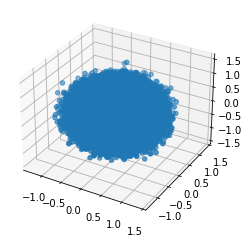

In [12]:
pc_df = pd.DataFrame(data=pc, columns=['PC1', 'PC2', 'PC3'])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'])
plt.show()

---

## Towards the Future 🚀

Other languages supported by Apache Arrow:
* R
* Matlab
* Julia
* and more!

Some ponderings:
* can we do better bulk updates/writes by moving data via Arrow to the server?
* how about replicating an entire in-memory graph to another Neo4j system?
* if we ditch the whole 2-step process (get ticket, get stream) how simple can our DX be?
